In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Model

In [10]:
class ANNModel(nn.Module):
    def __init__(self, input_dim,hidden_dim,output_dim,randomStartMatrix=False):
        super(ANNModel, self).__init__()
        lm=[input_dim]+hidden_dim+[output_dim]
        self.hiddenLayers=nn.ModuleList()
        for i in range(len(lm)-1):
            self.hiddenLayers.append(nn.Linear(lm[i],lm[i+1]))
        #print(len(lm))
        #print(lm)
        if randomStartMatrix:
            weights=self.state_dict()
            for w in weights.keys():
                weights[w]=torch.tensor((numpy.random.random(weights[w].shape)*2.0)-1.0)
            self.load_state_dict(weights)


    def forward(self, x):
        out=x
        for i in range(len(self.hiddenLayers)-1):
            out = torch.tanh(self.hiddenLayers[i](out))
        out = torch.tanh(self.hiddenLayers[-1](out))
        return out

myANN=ANNModel(28*28,[10,10],5,randomStartMatrix=False)
myANN

ANNModel(
  (hiddenLayers): ModuleList(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
  )
)

# Patterns

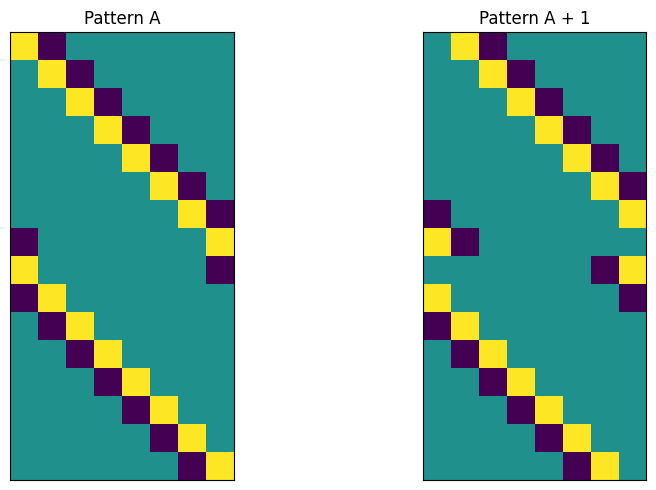

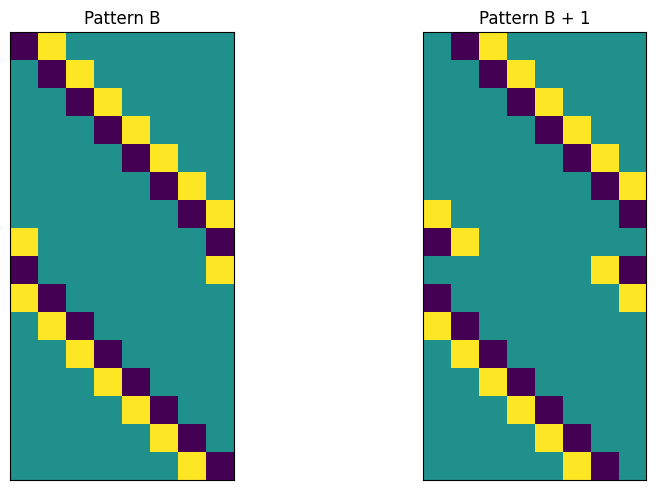

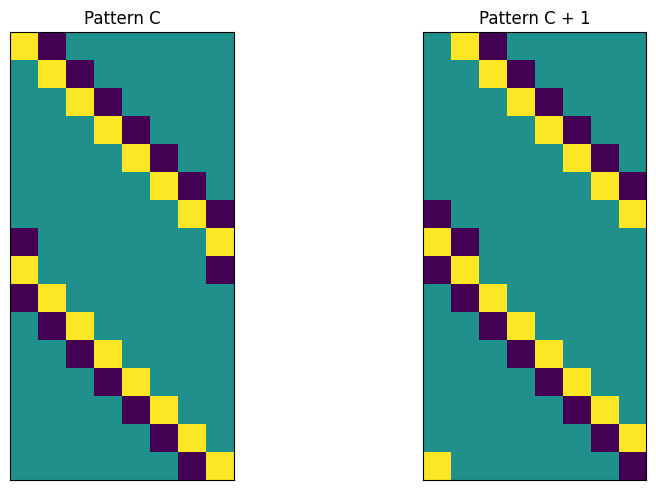

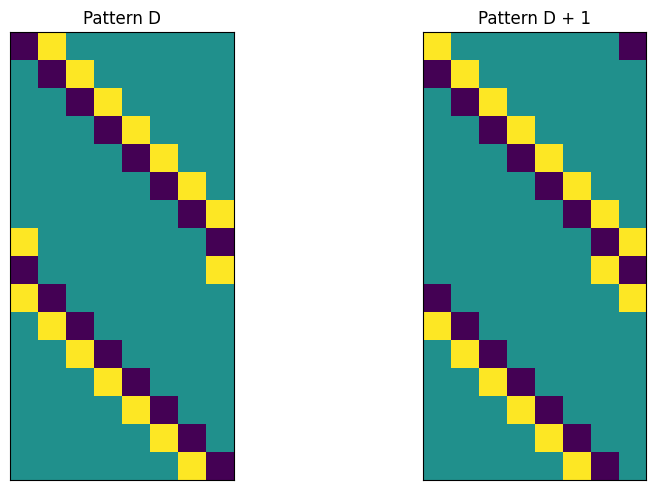

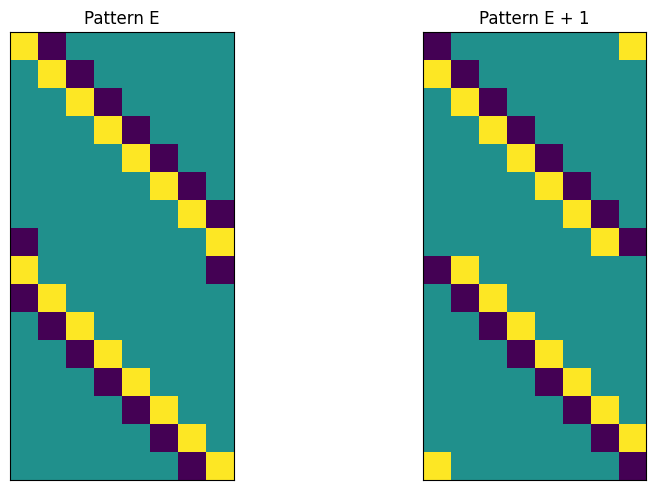

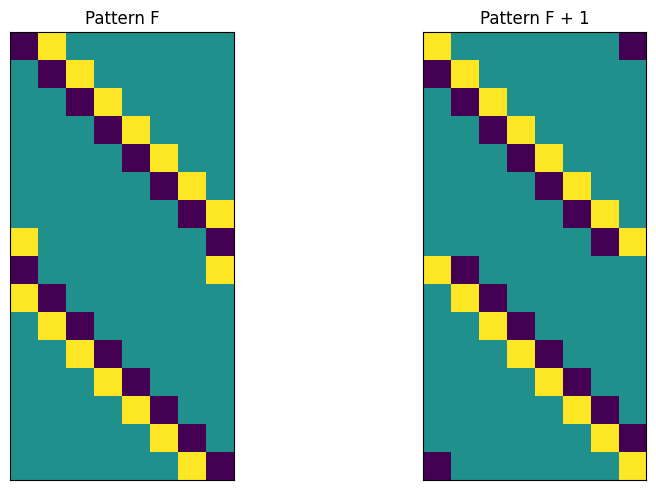

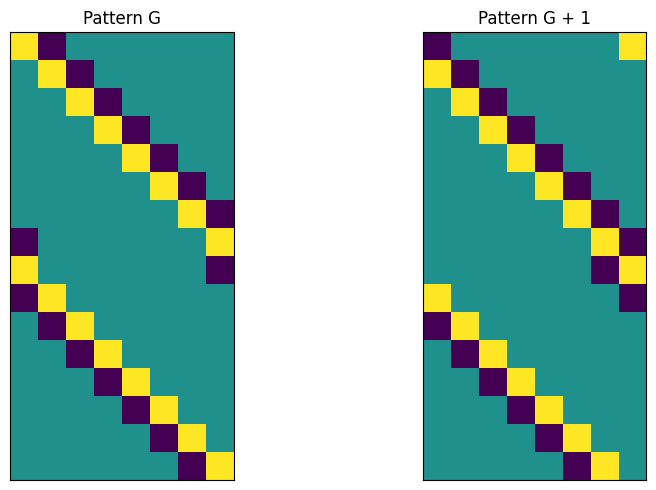

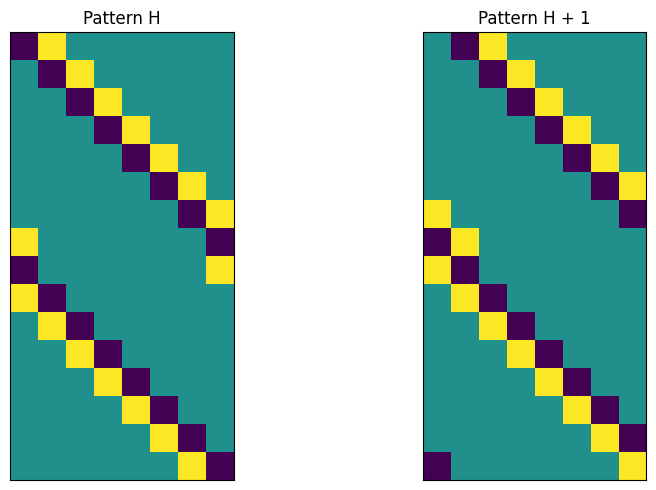

In [11]:
# Function to plot a pattern
def plot_pattern(ax, pattern, title):
    ax.imshow(pattern, cmap='viridis')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

# Function to create and plot a pattern and its transformation
def plot_pattern_and_transformations(pattern, pattern_plus_1, title, title_plus_1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_pattern(axs[0], pattern, title)
    plot_pattern(axs[1], pattern_plus_1, title_plus_1)
    plt.tight_layout()
    plt.show()

# Creating patterns A and A+1
patternA = []
patternA_plus_1 = []
for d in [1, -1]:
    for i in range(8):
        A = [0] * 8
        B = [0] * 8
        A[i] = 1.0
        A[(i + d) & 7] = -1.0
        B[(i + d) & 7] = 1.0
        B[(i + (d * 2)) & 7] = -1.0
        patternA.append(A)
        patternA_plus_1.append(B)

patternA = np.array(patternA)
patternA_plus_1 = np.array(patternA_plus_1)

# Creating patterns B and B+1 by changing 1 to -1 and -1 to 1 in A and A+1
patternB = np.where(patternA == 0, 0, -patternA)
patternB_plus_1 = np.where(patternA_plus_1 == 0, 0, -patternA_plus_1)

# Creating patterns C and C+1 by shifting each row of A one place to the right
patternC = np.copy(patternA)
patternC_plus_1 = np.array([np.roll(row, 1) for row in patternC])

# Creating patterns D and D+1 (similar to B but shifted one place to the right)
patternD = np.copy(patternB)
patternD_plus_1 = np.array([np.roll(row, -1) for row in patternD])

# Creating patterns E and E+1 based on transformations for A
patternE = np.copy(patternA)
patternE_plus_1 = np.zeros_like(patternA)
halfway_point = len(patternA) // 2
patternE_plus_1[:halfway_point] = np.roll(patternA[:halfway_point], -1, axis=1)
patternE_plus_1[halfway_point:] = np.roll(patternA[halfway_point:], 1, axis=1)

# Creating patterns F and F+1 with similar logic to E but applied to B
patternF = np.copy(patternB)
patternF_plus_1 = np.zeros_like(patternB)
patternF_plus_1[:halfway_point] = np.roll(patternB[:halfway_point], -1, axis=1)
patternF_plus_1[halfway_point:] = np.roll(patternB[halfway_point:], 1, axis=1)

# Creating patterns G and G+1 based on transformations for A
patternG = np.copy(patternA)
patternG_plus_1 = np.array([np.roll(row, -1) for row in patternG])

# Creating patterns H and H+1 based on transformations for B
patternH = np.copy(patternB)
patternH_plus_1 = np.array([np.roll(row, 1) for row in patternH])

# Plotting the patterns and their transformations
plot_pattern_and_transformations(patternA, patternA_plus_1, "Pattern A", "Pattern A + 1")
plot_pattern_and_transformations(patternB, patternB_plus_1, "Pattern B", "Pattern B + 1")
plot_pattern_and_transformations(patternC, patternC_plus_1, "Pattern C", "Pattern C + 1")
plot_pattern_and_transformations(patternD, patternD_plus_1, "Pattern D", "Pattern D + 1")
plot_pattern_and_transformations(patternE, patternE_plus_1, "Pattern E", "Pattern E + 1")
plot_pattern_and_transformations(patternF, patternF_plus_1, "Pattern F", "Pattern F + 1")
plot_pattern_and_transformations(patternG, patternG_plus_1, "Pattern G", "Pattern G + 1")
plot_pattern_and_transformations(patternH, patternH_plus_1, "Pattern H", "Pattern H + 1")


## Mixing pattern for testing

In [5]:
def createmixedpattern_unchanged(A, C, A_plus_1, C_plus_1, fraction):
    
    # Check if fraction is 1, which means only A should be used
    if fraction == 1:
        return A, A_plus_1
    
    # Calculate the number of rows from pattern A and pattern C to be included
    num_rows_A = int(fraction * len(A))
    num_rows_B = len(A) - num_rows_A

    # Create mixed patterns
    mixedpattern = np.vstack((A[:num_rows_A], C[-num_rows_B:]))
    mixedpattern_plus_1 = np.vstack((A_plus_1[:num_rows_A], C_plus_1[-num_rows_B:]))

    return mixedpattern, mixedpattern_plus_1


## Mixing Pattern for training

In [12]:

def createmixedpattern(A, C, A_plus_1, C_plus_1, fraction):
    # Calculate the number of rows from patterns A and C to be included
    num_rows_A = int(fraction * len(A))
   
    num_rows_C = len(C) - num_rows_A
   

    # Randomly select rows from patterns A and C
    selected_rows_A = np.random.choice(len(A), num_rows_A, replace=False)
    selected_rows_C = np.random.choice(len(C), num_rows_C, replace=False)

    # Create mixed patterns using the randomly selected rows
    mixedpattern = np.vstack((A[selected_rows_A], C[selected_rows_C]))
    mixedpattern_plus_1 = np.vstack((A_plus_1[selected_rows_A], C_plus_1[selected_rows_C]))

    # Randomize the order of the stacked rows
    mixed_order = np.random.permutation(len(mixedpattern))
    mixedpattern = mixedpattern[mixed_order]
    mixedpattern_plus_1 = mixedpattern_plus_1[mixed_order]

    return mixedpattern, mixedpattern_plus_1


# Learning ability of the model with different patterns

In [7]:
#Training code

def train_model(pattern, pattern_transformed, epochs=3000, learning_rate=0.001):
    model = ANNModel(8, [16], 8, randomStartMatrix=False)  # Assuming ANNModel initialization
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    error = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Add noise to pattern input
        input_pattern = torch.Tensor(pattern + np.random.uniform(0.0, 0.2, pattern.shape))
        output = model(input_pattern)
        loss = error(output, torch.Tensor(pattern_transformed))
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

    return model, losses


In [8]:
def test_model(model, patterns, patterns_transformed):
    error = nn.MSELoss()
    model.eval()  # Set model to evaluation mode
    mse_scores = []
    predicted_patterns = []
    
    with torch.no_grad():
        for pattern, pattern_transformed in zip(patterns, patterns_transformed):
            input_pattern = torch.Tensor(pattern + np.random.uniform(0.0, 0.2, pattern.shape))
            predicted = model(input_pattern)
            mse = error(predicted, torch.Tensor(pattern_transformed))
            mse_scores.append(float(mse))
            predicted_patterns.append(predicted.numpy())
    
    return mse_scores, predicted_patterns


In [9]:

def plot_prediction_comparison(original_pattern, predicted_pattern, transformed_pattern):
    """
    Plots a comparison between an original pattern, its predicted transformation, and the actual transformation.

    Parameters:
    - original_pattern: numpy.ndarray, the original pattern.
    - predicted_pattern: list, the predicted pattern from the model, will be converted to a numpy array.
    - transformed_pattern: numpy.ndarray, the actual transformed pattern.
    """

    # Convert predicted pattern to numpy array and reshape if necessary
    predicted_tensor = np.array(predicted_pattern)
    if predicted_tensor.shape != original_pattern.shape:
        predicted_tensor = predicted_tensor.reshape(original_pattern.shape)

    # Plotting the patterns
    plt.figure(figsize=(18, 6))

    # Plot original pattern
    plt.subplot(1, 3, 1)
    plt.imshow(original_pattern, cmap='gray')
    plt.title("Original Pattern")
    plt.colorbar()

    # Plot predicted pattern
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_tensor, cmap='gray')
    plt.title("Predicted Pattern")
    plt.colorbar()

    # Plot transformed pattern
    plt.subplot(1, 3, 3)
    plt.imshow(transformed_pattern, cmap='gray')
    plt.title("Transformed Pattern")
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [10]:
# Example seeds set for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

Results for Pattern A:


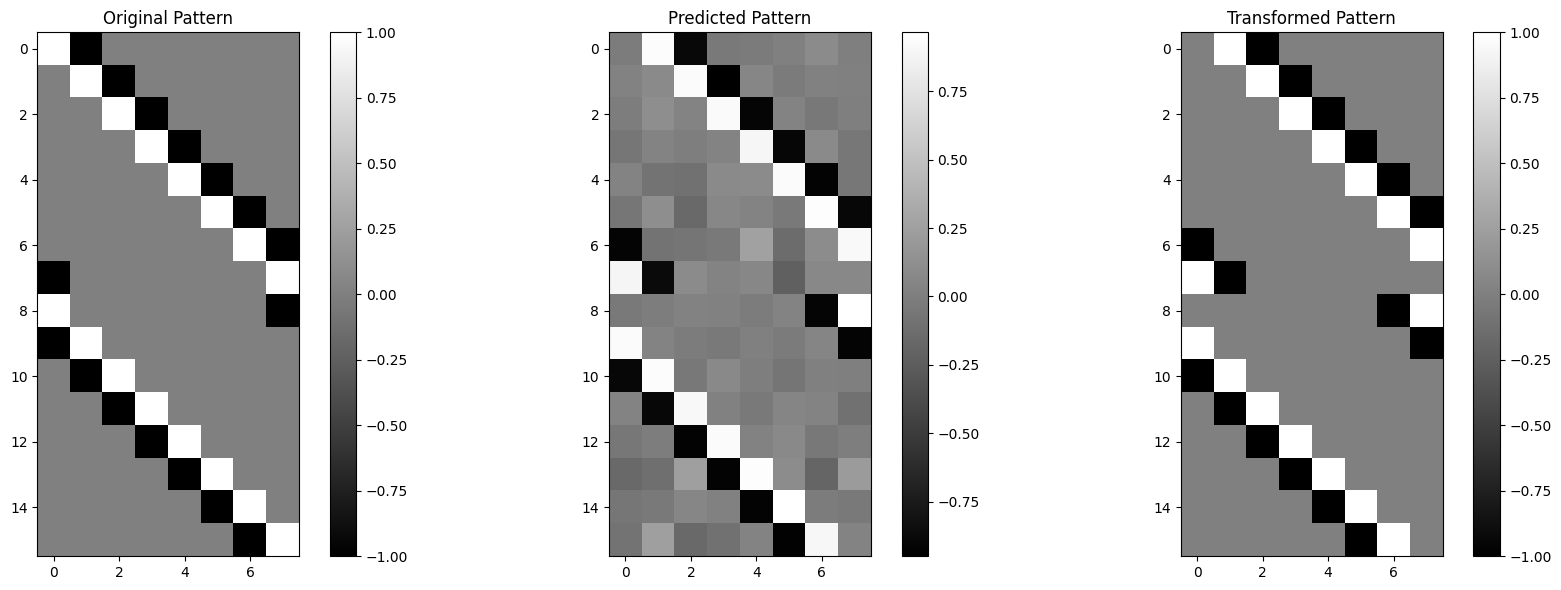

Results for Pattern B:


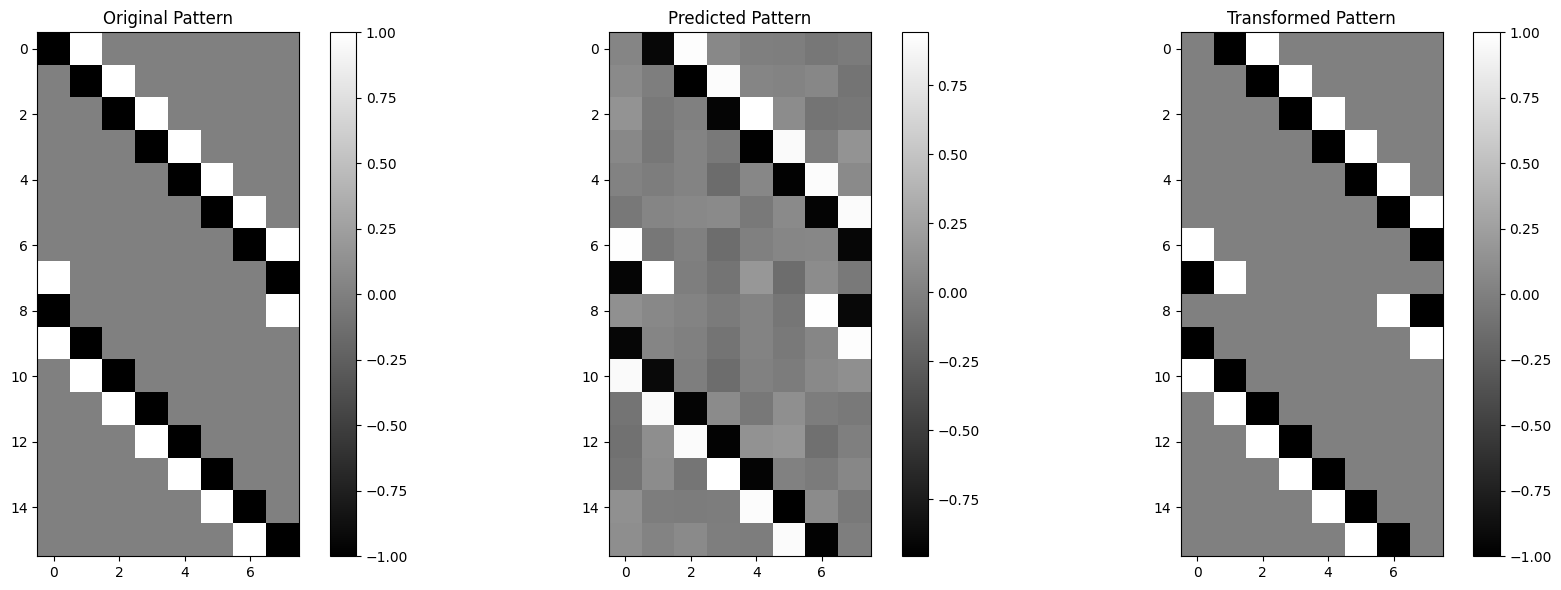

Results for Pattern C:


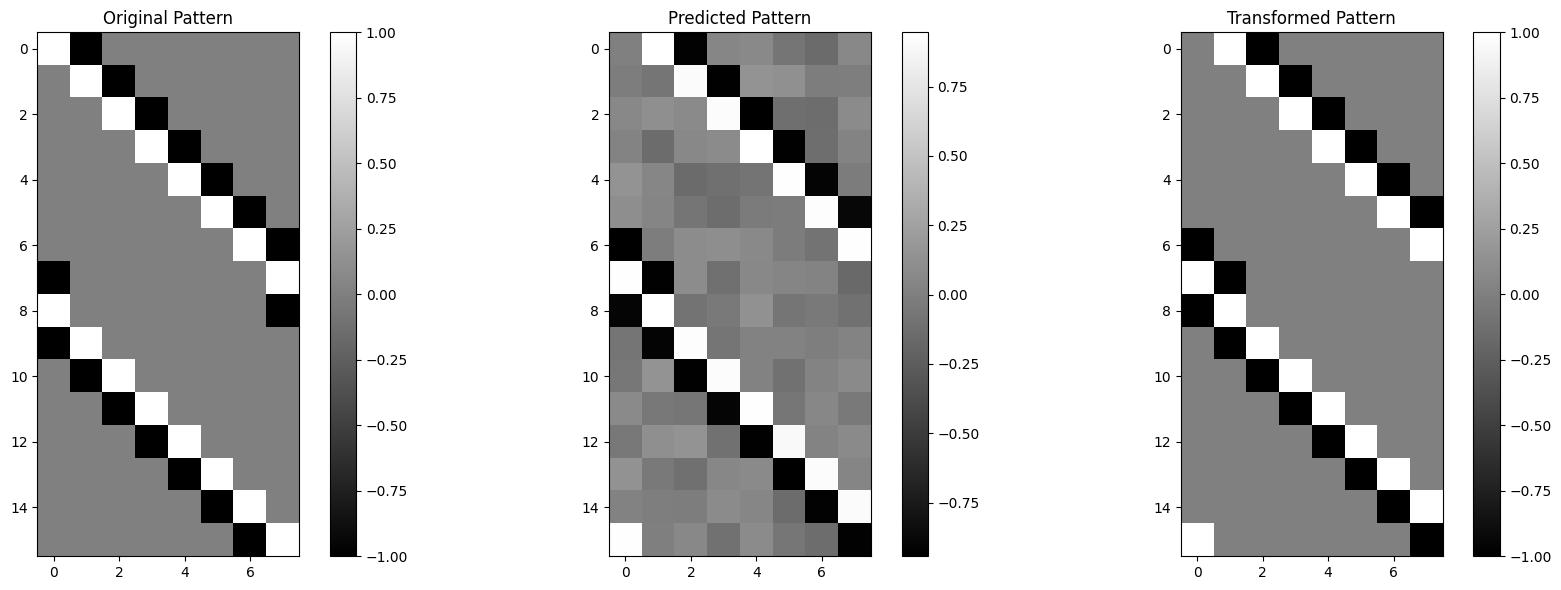

Results for Pattern D:


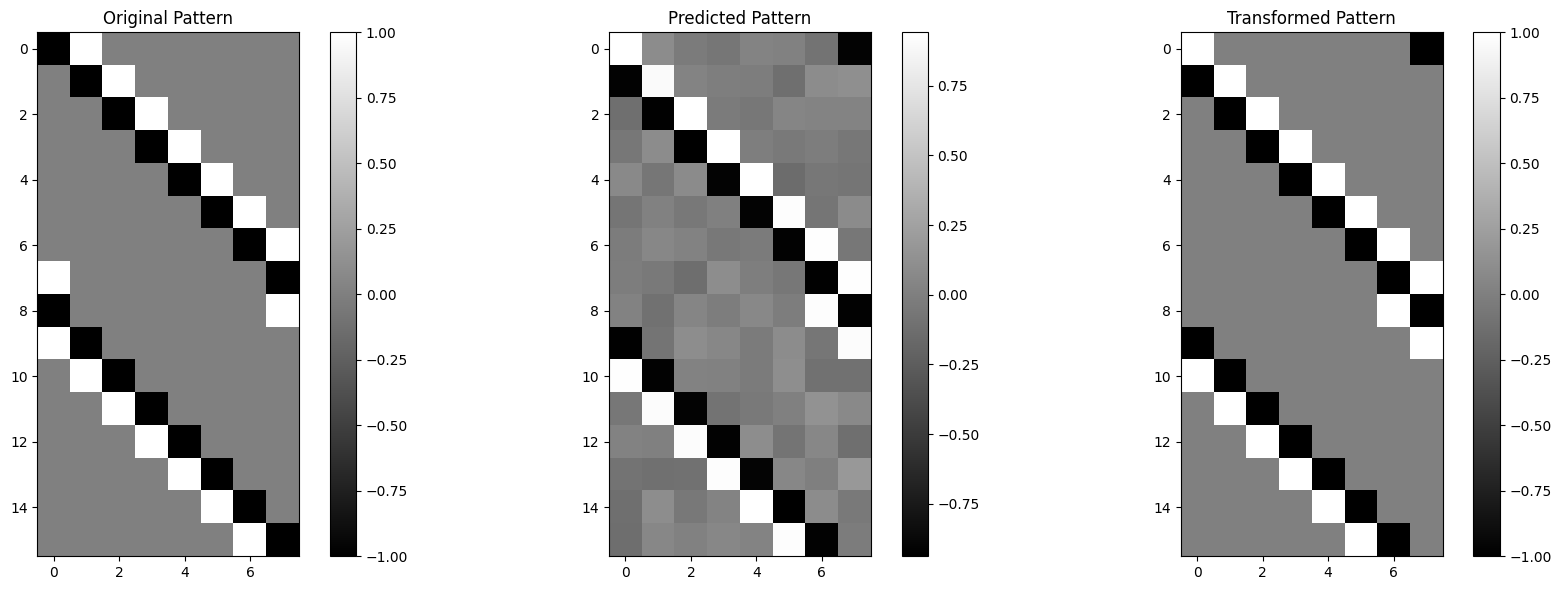

Results for Pattern E:


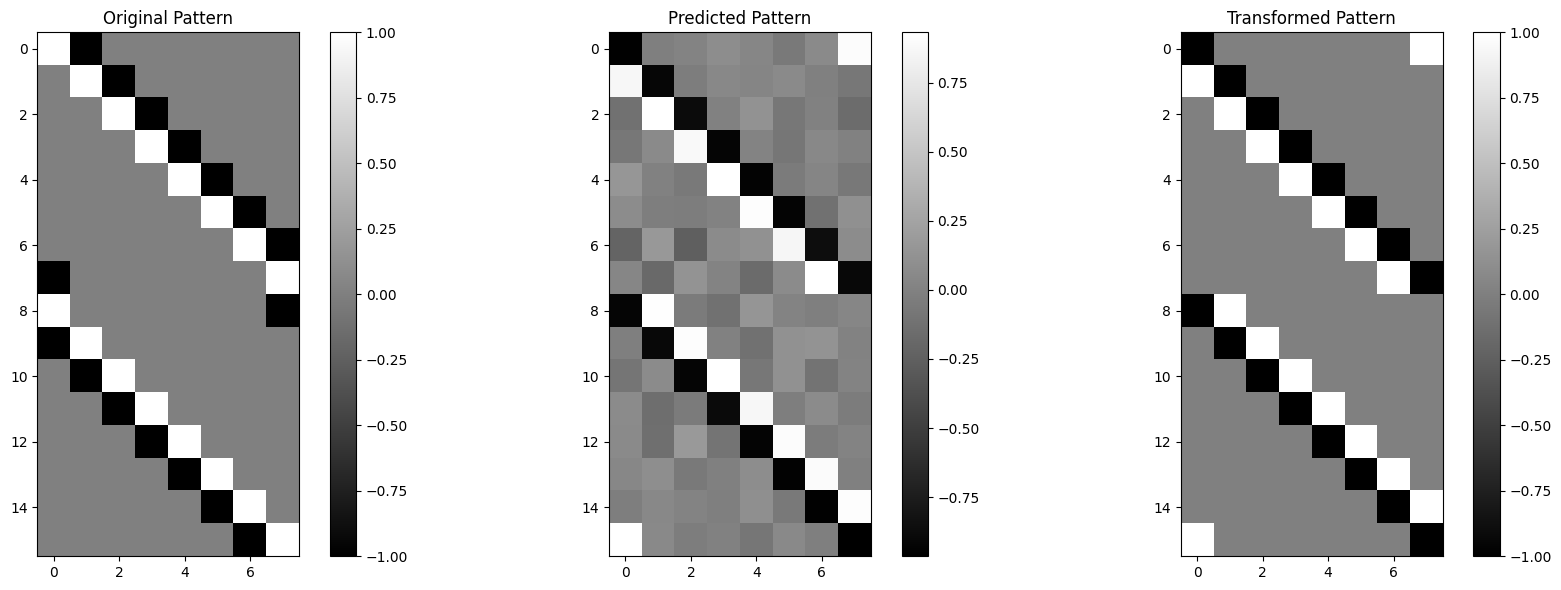

Results for Pattern F:


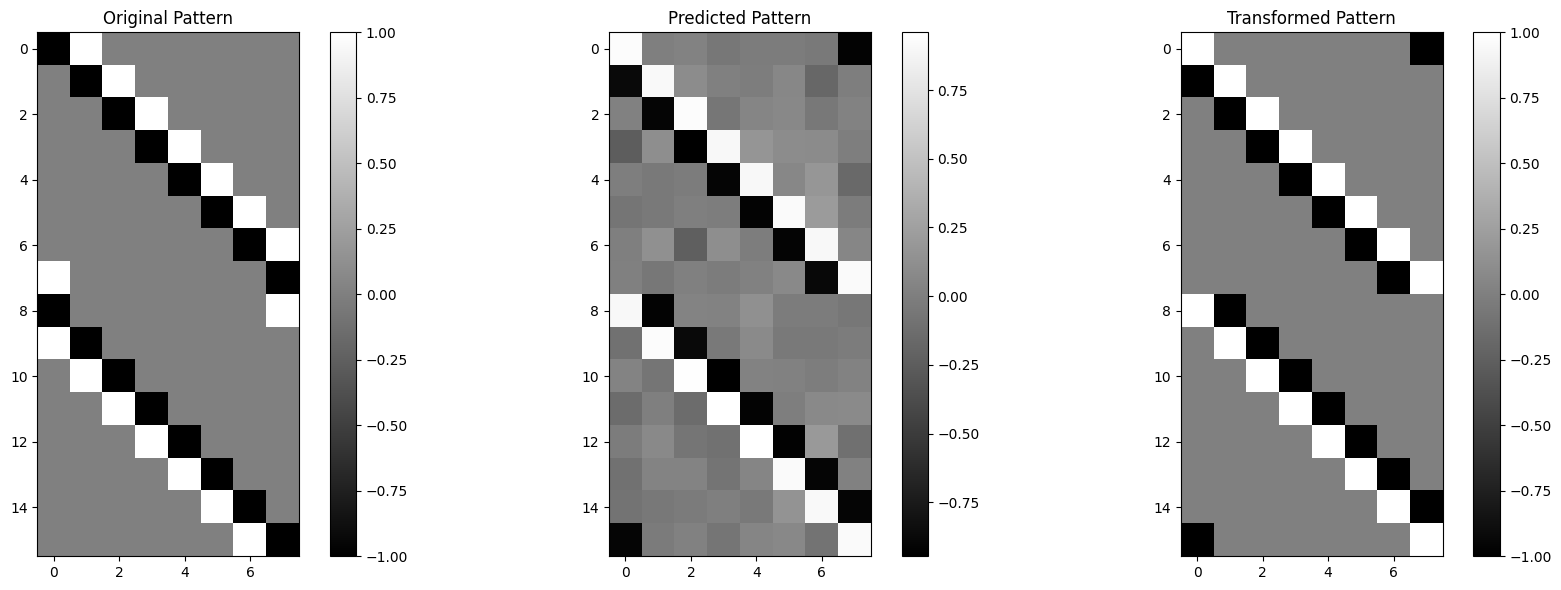

Results for Pattern G:


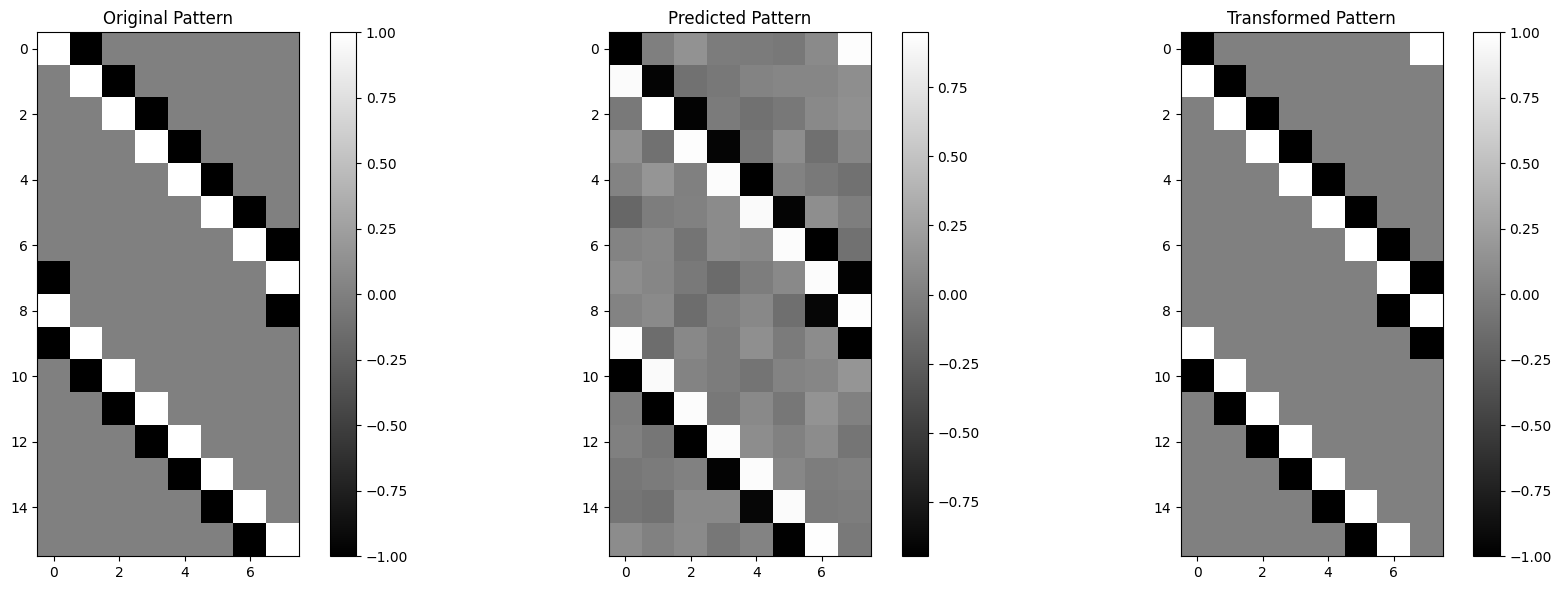

Results for Pattern H:


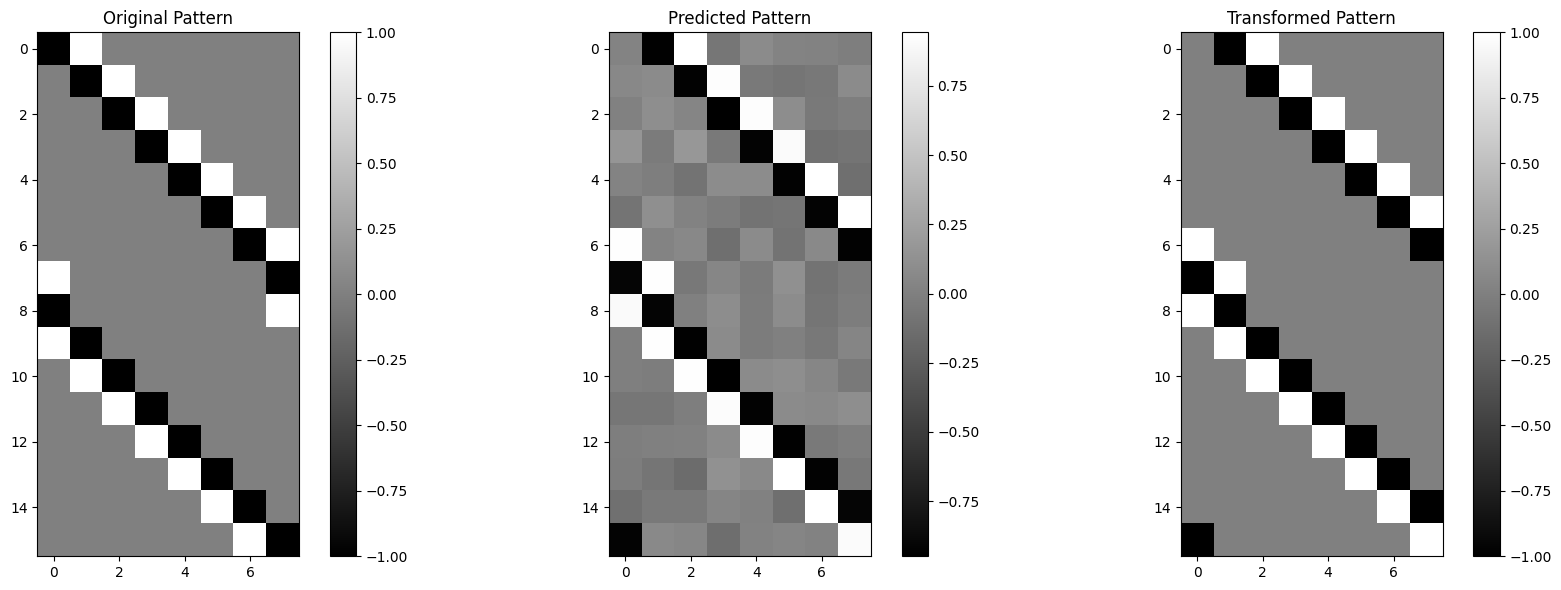

In [11]:
patterns = [
    (patternA, patternA_plus_1, 'Pattern A'),
    (patternB, patternB_plus_1, 'Pattern B'),
    (patternC, patternC_plus_1, 'Pattern C'),
    (patternD, patternD_plus_1, 'Pattern D'),
    (patternE, patternE_plus_1, 'Pattern E'),
    (patternF, patternF_plus_1, 'Pattern F'),
    (patternG, patternG_plus_1, 'Pattern G'),
    (patternH, patternH_plus_1, 'Pattern H'),
]

for original_pattern, transformed_pattern, pattern_name in patterns:
    # Train the model with the current pattern
    model, losses = train_model(original_pattern, transformed_pattern, epochs=3000, learning_rate=0.001)
    
    # Test the model with the current pattern
    mse_scores, predicted_patterns = test_model(model, [original_pattern], [transformed_pattern])
    
    # Plot the prediction comparison
    print(f"Results for {pattern_name}:")
    plot_prediction_comparison(original_pattern, predicted_patterns[0], transformed_pattern)


## MSE for each pattern

In [12]:

# List of pattern pairs for training and testing
patterns = [
    (patternA, patternA_plus_1, 'Pattern A'),
    (patternB, patternB_plus_1, 'Pattern B'),
    (patternC, patternC_plus_1, 'Pattern C'),
    (patternD, patternD_plus_1, 'Pattern D'),
    (patternE, patternE_plus_1, 'Pattern E'),
    (patternF, patternF_plus_1, 'Pattern F'),
    (patternG, patternG_plus_1, 'Pattern G'),
    (patternH, patternH_plus_1, 'Pattern H'),
]

# Initialize a dictionary to hold the average MSE for each pattern
average_mse_scores = {}

# Train and test the model for each pattern
for original_pattern, transformed_pattern, pattern_name in patterns:
    print(f"Training and testing for {pattern_name}...")
    # Train the model with the current pattern
    model, losses = train_model(original_pattern, transformed_pattern, epochs=10000, learning_rate=0.001)
    
    # Test the model with the current pattern
    mse_scores, predicted_patterns = test_model(model, [original_pattern], [transformed_pattern])
    
    # Calculate the average MSE score for the current pattern
    avg_mse = np.mean(mse_scores)
    average_mse_scores[pattern_name] = avg_mse
    
    print(f"Average MSE for {pattern_name}: {avg_mse}")

# Identify the pattern with the highest average MSE score
# Manually find the pattern with the highest average MSE score
highest_mse = float('-inf')
hardest_pattern = None
for pattern, mse in average_mse_scores.items():
    if mse > highest_mse:
        highest_mse = mse
        hardest_pattern = pattern

print(f"The hardest pattern to learn is {hardest_pattern} with an average MSE of {highest_mse}.")


Training and testing for Pattern A...
Average MSE for Pattern A: 0.004544984549283981
Training and testing for Pattern B...
Average MSE for Pattern B: 0.005273975431919098
Training and testing for Pattern C...
Average MSE for Pattern C: 0.0030228246469050646
Training and testing for Pattern D...
Average MSE for Pattern D: 0.002805627416819334
Training and testing for Pattern E...
Average MSE for Pattern E: 0.004895585123449564
Training and testing for Pattern F...
Average MSE for Pattern F: 0.004636630415916443
Training and testing for Pattern G...
Average MSE for Pattern G: 0.002386198379099369
Training and testing for Pattern H...
Average MSE for Pattern H: 0.0017275114078074694
The hardest pattern to learn is Pattern B with an average MSE of 0.005273975431919098.


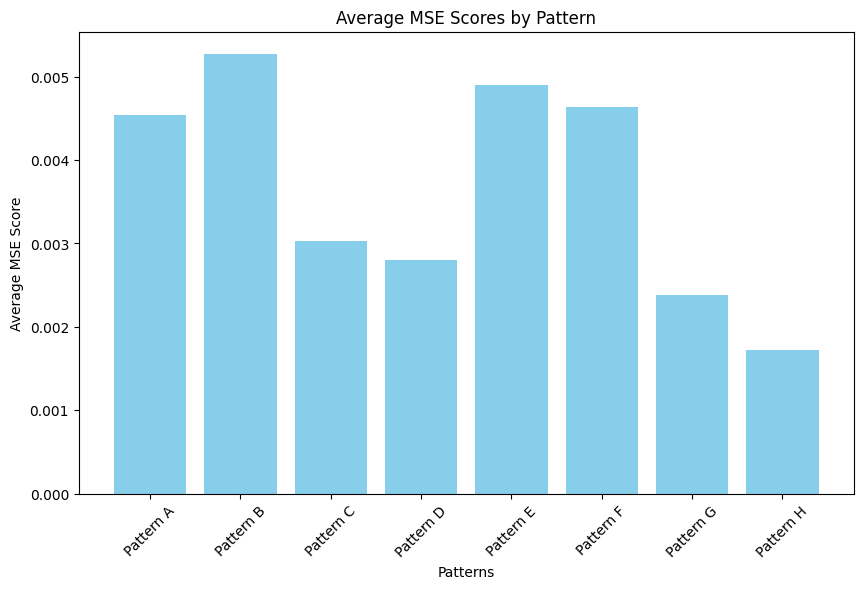

In [13]:
# Extract pattern names and their corresponding MSE scores
patterns = list(average_mse_scores.keys())
mse_scores = list(average_mse_scores.values())

# Creating the bar plot
plt.figure(figsize=(10, 6))
plt.bar(patterns, mse_scores, color='skyblue')
plt.xlabel('Patterns')
plt.ylabel('Average MSE Score')
plt.title('Average MSE Scores by Pattern')
plt.xticks(rotation=45)
plt.show()


## Epochs needed to reach a certain accuracy

In [14]:

def calculate_binary_accuracy(model_output, target, threshold=0.9):
    """
    Calculate accuracy by categorizing predictions based on a threshold,
    then comparing with the categorized target values.
    """
    # Categorize predictions
    predictions = torch.zeros_like(model_output)
    predictions[model_output < -threshold] = -1
    predictions[(model_output >= -threshold) & (model_output < threshold)] = 0
    predictions[model_output >= threshold] = 1
    
    # Ensure target is a tensor (if it's not already)
    target = torch.tensor(target, dtype=torch.float32)
    
    # Element-wise comparison
    correct = torch.eq(predictions, target).float()
    return correct.mean().item()


def train_model_until_accuracy(pattern, pattern_transformed, desired_accuracy=0.9, epochs=20000, learning_rate=0.001):
    model = ANNModel(8, [16], 8, randomStartMatrix=False)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    error = nn.MSELoss()
    for epoch in range(epochs):
        optimizer.zero_grad()
        input_pattern = torch.Tensor(pattern + np.random.uniform(0.0, 0.2, pattern.shape))
        output = model(input_pattern)
        loss = error(output, torch.Tensor(pattern_transformed))
        loss.backward()
        optimizer.step()

        # Calculate "accuracy" after each epoch and stop if it exceeds the desired threshold
       
        current_accuracy = calculate_binary_accuracy(output, torch.Tensor(pattern_transformed))
        if current_accuracy >= desired_accuracy:
            print(f"Achieved {desired_accuracy*100}% accuracy at epoch {epoch+1}")
            break
    return model, epoch+1


In [15]:
patterns = [
    (patternA, patternA_plus_1, 'Pattern A'),
    (patternB, patternB_plus_1, 'Pattern B'),
    (patternC, patternC_plus_1, 'Pattern C'),
    (patternD, patternD_plus_1, 'Pattern D'),
    (patternE, patternE_plus_1, 'Pattern E'),
    (patternF, patternF_plus_1, 'Pattern F'),
    (patternG, patternG_plus_1, 'Pattern G'),
    (patternH, patternH_plus_1, 'Pattern H'),
]

# Dictionary to hold the epochs needed for each pattern to reach 90% accuracy
epochs_needed_for_patterns = {}

for pattern, pattern_transformed, pattern_name in patterns:
    print(f"Training for {pattern_name}...")
    model, epochs_needed = train_model_until_accuracy(pattern, pattern_transformed, desired_accuracy=0.90)
    epochs_needed_for_patterns[pattern_name] = epochs_needed
    print(f"{pattern_name}: Needed {epochs_needed} epochs to reach 90% accuracy.\n")

# Printing a summary of the results
print("Summary of epochs needed to reach 90% accuracy for each pattern:")
for pattern_name, epochs_needed in epochs_needed_for_patterns.items():
    print(f"{pattern_name}: {epochs_needed} epochs")


Training for Pattern A...


/var/folders/wn/f4cc27tx13g8w1qgpzb2bsrm0000gn/T/ipykernel_6899/3201989609.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.float32)


Achieved 90.0% accuracy at epoch 1884
Pattern A: Needed 1884 epochs to reach 90% accuracy.

Training for Pattern B...
Achieved 90.0% accuracy at epoch 1862
Pattern B: Needed 1862 epochs to reach 90% accuracy.

Training for Pattern C...
Achieved 90.0% accuracy at epoch 844
Pattern C: Needed 844 epochs to reach 90% accuracy.

Training for Pattern D...
Achieved 90.0% accuracy at epoch 750
Pattern D: Needed 750 epochs to reach 90% accuracy.

Training for Pattern E...
Achieved 90.0% accuracy at epoch 1610
Pattern E: Needed 1610 epochs to reach 90% accuracy.

Training for Pattern F...
Achieved 90.0% accuracy at epoch 1767
Pattern F: Needed 1767 epochs to reach 90% accuracy.

Training for Pattern G...
Achieved 90.0% accuracy at epoch 841
Pattern G: Needed 841 epochs to reach 90% accuracy.

Training for Pattern H...
Achieved 90.0% accuracy at epoch 931
Pattern H: Needed 931 epochs to reach 90% accuracy.

Summary of epochs needed to reach 90% accuracy for each pattern:
Pattern A: 1884 epochs
Pa

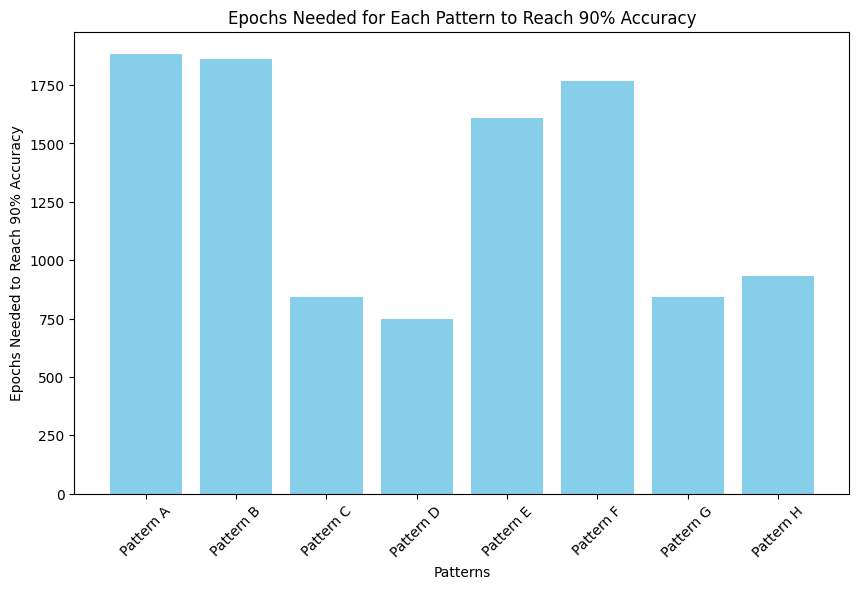

In [16]:
# Extracting pattern names and epochs needed for plotting
patterns = list(epochs_needed_for_patterns.keys())
epochs_needed = list(epochs_needed_for_patterns.values())

# Creating the plot
plt.figure(figsize=(10, 6))
plt.bar(patterns, epochs_needed, color='skyblue')
plt.xlabel('Patterns')
plt.ylabel('Epochs Needed to Reach 90% Accuracy')
plt.title('Epochs Needed for Each Pattern to Reach 90% Accuracy')
plt.xticks(rotation=45)
plt.show()


# Model Training A-B

In [13]:

# Directory where the models are saved
models_dir = 'Models_A-B'

N = 10  # Number of models
epochs = 5000
fractions = np.arange(0, 101, 10) / 100  # Fractions from 0% to 100%

for i in range(N):
    
    for fraction_index, fraction in enumerate(fractions):

        mixedpattern, mixedpattern_plus_1 = createmixedpattern(patternA, patternB, patternA_plus_1, patternB_plus_1, fraction)
        
        L = []  # List to store MSE for each epoch

        # Initialize a single model and its optimizer
        model = ANNModel(8, [16], 8, randomStartMatrix=False)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        error = nn.MSELoss()

        for epoch in range(epochs):

            optimizer.zero_grad()
            output = model(torch.Tensor(mixedpattern + np.random.uniform(0.0, 0.2, mixedpattern.shape)))
            loss = error(output, torch.Tensor(mixedpattern_plus_1))
            loss.backward()
            optimizer.step()
            L.append(float(loss))
            
            mixedpattern, mixedpattern_plus_1 = createmixedpattern(patternA, patternB, patternA_plus_1, patternB_plus_1, fraction)

        # Save the model after training for this fraction is complete
        model_filename = f'{models_dir}/model_{i+1}_fraction_{int(fraction*100)}.pth'
        torch.save(model.state_dict(), model_filename)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


def load_model(model_path):
    model = ANNModel(8, [16], 8, randomStartMatrix=False)  # Adjust parameters as per your model definition
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Model Testing A-B

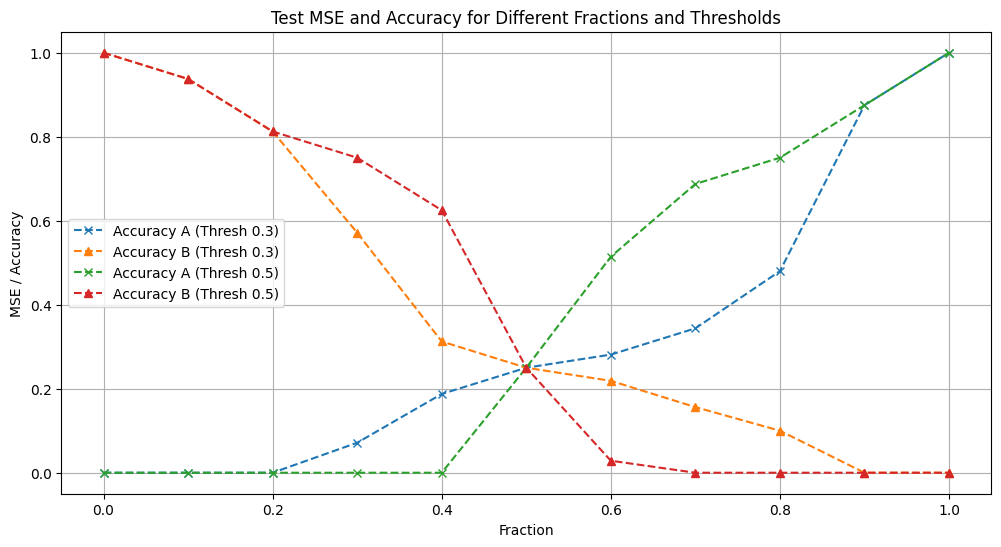

In [15]:

# Directory where the models are saved
models_dir = 'Models_A-B'

# Fractions from 0% to 100%
fractions = np.arange(0, 101, 10) / 100

# Thresholds for accuracy calculation
thresholds = [0.3, 0.5]

# Initialize dictionaries to store test MSE and accuracies for each fraction and threshold
all_test_mse = []
all_test_accuracy_A = {thresh: [] for thresh in thresholds}
all_test_accuracy_B = {thresh: [] for thresh in thresholds}


for fraction in fractions:
    # Generate Test Data for the current fraction
    mixedpattern, mixedpattern_plus_1 = createmixedpattern_unchanged(patternA, patternB, patternA_plus_1, patternB_plus_1, fraction)
    # mixedpattern, mixedpattern_plus_1 = patternA, patternA_plus_1
    # Dynamically generate model paths for each fraction and load all models
    model_paths = [f'{models_dir}/model_{i+1}_fraction_{int(fraction*100)}.pth' for i in range(N)]  # Adjust for the number of models
    models = [load_model(path) for path in model_paths]

    # Use all models to predict on the same data and average the results
    ensemble_predictions = []
    
    with torch.no_grad():
        for index, model in enumerate(models):
            predicted = model(torch.Tensor(mixedpattern))
            ensemble_predictions.append(predicted.numpy())

        # Calculate the mean prediction across all models
        ensemble_mean_prediction = np.mean(np.stack(ensemble_predictions), axis=0)

        if index == 1 and fraction in [0.9]:

            predicted_tensor = ensemble_mean_prediction  

            # Ensure all patterns have the same shape for plotting
            if predicted_tensor.shape != mixedpattern.shape:
                predicted_tensor = predicted_tensor.reshape(mixedpattern.shape)

            # Plotting the patterns
            plt.figure(figsize=(18, 6))

            # Plot mixedpattern
            plt.subplot(1, 3, 1)
            plt.imshow(mixedpattern, cmap='gray')
            plt.title("Mixed Pattern")
            plt.colorbar()

            # Plot predicted pattern
            plt.subplot(1, 3, 2)
            plt.imshow(predicted_tensor, cmap='gray')
            plt.title("Predicted Pattern")
            plt.colorbar()

            # Plot mixedpattern_plus_1
            plt.subplot(1, 3, 3)
            plt.imshow(mixedpattern_plus_1, cmap='gray')
            plt.title("Mixed Pattern Plus 1")
            plt.colorbar()

            plt.tight_layout()
            plt.show()

        # Calculate MSE
        mse_loss = mean_squared_error(mixedpattern_plus_1, ensemble_mean_prediction)
        all_test_mse.append(mse_loss)

        for thresh in thresholds:
            # Calculate accuracies for A and B
            categorized_predictions = np.select(
                [ensemble_mean_prediction < -thresh, ensemble_mean_prediction < thresh, ensemble_mean_prediction >= thresh],
                [-1, 0, 1]
            )
            
            # Filter predictions and truth values where predictions are not 0
            filter_mask = categorized_predictions != 0
            filtered_predictions_A = categorized_predictions[filter_mask]
            filtered_truth_A = patternA_plus_1[filter_mask]
            filtered_predictions_B = categorized_predictions[filter_mask]
            filtered_truth_B = patternB_plus_1[filter_mask]

            accuracy_A = np.mean(filtered_predictions_A == filtered_truth_A)
            accuracy_B = np.mean(filtered_predictions_B == filtered_truth_B)
            
            all_test_accuracy_A[thresh].append(accuracy_A)
            all_test_accuracy_B[thresh].append(accuracy_B)

# Plotting results
plt.figure(figsize=(12, 6))
#plt.plot(fractions, all_test_mse, marker='o', linestyle='-', color='red', label='MSE')
for thresh in thresholds:
    plt.plot(fractions, all_test_accuracy_A[thresh], marker='x', linestyle='--', label=f'Accuracy A (Thresh {thresh})')
    plt.plot(fractions, all_test_accuracy_B[thresh], marker='^', linestyle='--', label=f'Accuracy B (Thresh {thresh})')

plt.title('Test MSE and Accuracy for Different Fractions and Thresholds')
plt.xlabel('Fraction')
plt.ylabel('MSE / Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... assume all necessary functions and variables are defined, such as load_model, createmixedpattern_unchanged, etc.

# Directory where the models are saved
models_dir = 'Models_A-B'

# Fractions from 0% to 100%
fractions = np.arange(0, 101, 10) / 100

# Thresholds for accuracy calculation
thresholds = [0.3, 0.5]

# Initialize dictionaries to store test accuracies for each model, fraction, and threshold
all_test_accuracy_A = {thresh: {fraction: [] for fraction in fractions} for thresh in thresholds}
all_test_accuracy_B = {thresh: {fraction: [] for fraction in fractions} for thresh in thresholds}

# Iterate over each fraction
for fraction in fractions:
    # Generate Test Data for the current fraction
    mixedpattern, mixedpattern_plus_1 = createmixedpattern_unchanged(patternA, patternB, patternA_plus_1, patternB_plus_1, fraction)

    # Dynamically generate model paths for this fraction
    model_paths = [f'{models_dir}/model_{i+1}_fraction_{int(fraction*100)}.pth' for i in range(10)]  # Adjust for the number of models

    # Load the models for this fraction
    models = [load_model(path) for path in model_paths]

    # Calculate the accuracy for each model separately
    for index, model in enumerate(models):
        # Get predictions for the current model
        with torch.no_grad():
            predicted = model(torch.Tensor(mixedpattern)).numpy()

        # Calculate accuracies for each threshold
        for thresh in thresholds:
            categorized_predictions = np.select(
                [predicted < -thresh, predicted < thresh, predicted >= thresh],
                [-1, 0, 1]
            )
            
            # Filter predictions and truth values where predictions are not 0
            filter_mask = categorized_predictions != 0
            filtered_predictions_A = categorized_predictions[filter_mask]
            filtered_truth_A = patternA_plus_1[filter_mask]
            filtered_predictions_B = categorized_predictions[filter_mask]
            filtered_truth_B = patternB_plus_1[filter_mask]

            # Calculate and store the accuracy for this model, fraction, and threshold
            accuracy_A = np.mean(filtered_predictions_A == filtered_truth_A)
            accuracy_B = np.mean(filtered_predictions_B == filtered_truth_B)

            all_test_accuracy_A[thresh][fraction].append(accuracy_A)
            all_test_accuracy_B[thresh][fraction].append(accuracy_B)

# After the loop, you will have the accuracy of each model for each fraction.
# You can then calculate mean, standard deviation, standard error, and confidence interval as needed.


In [40]:
all_test_accuracy_A

{0.3: {0.0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  0.1: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  0.2: [0.0,
   0.02702702702702703,
   0.0,
   0.0,
   0.05405405405405406,
   0.05263157894736842,
   0.0,
   0.0,
   0.0,
   0.0],
  0.3: [0.046511627906976744,
   0.05128205128205128,
   0.024390243902439025,
   0.022727272727272728,
   0.023809523809523808,
   0.08333333333333333,
   0.10638297872340426,
   0.09615384615384616,
   0.06666666666666667,
   0.044444444444444446],
  0.4: [0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875,
   0.1875],
  0.5: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
  0.6: [0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125,
   0.28125],
  0.7: [0.3548387096774194,
   0.36065573770491804,
   0.34375,
   0.34375,
   0.34375,
   0.36065573770491804,
   0.3548387096774194,
   0.3548387096774194,
   0.34375,
   0.360655

In [18]:
import scipy.stats

# Calculate mean, standard deviation, standard error, and confidence interval for each fraction and threshold
for thresh in thresholds:
    print(f"Threshold: {thresh}")
    for fraction in fractions:
        accuracies_A = all_test_accuracy_A[thresh][fraction]
        accuracies_B = all_test_accuracy_B[thresh][fraction]
        
        mean_A = np.mean(accuracies_A)
        std_dev_A = np.std(accuracies_A, ddof=1)  # ddof=1 for sample standard deviation
        stderr_A = scipy.stats.sem(accuracies_A, ddof=1)
        ci_A = scipy.stats.t.interval(0.95, len(accuracies_A)-1, loc=mean_A, scale=stderr_A)

        mean_B = np.mean(accuracies_B)
        std_dev_B = np.std(accuracies_B, ddof=1)  # ddof=1 for sample standard deviation
        stderr_B = scipy.stats.sem(accuracies_B, ddof=1)
        ci_B = scipy.stats.t.interval(0.95, len(accuracies_B)-1, loc=mean_B, scale=stderr_B)

        print(f"Fraction: {fraction:.2f}")
        print(f"Accuracy A: mean={mean_A:.3f}, std_dev={std_dev_A:.3f}, stderr={stderr_A:.3f}, ci={ci_A}")
        print(f"Accuracy B: mean={mean_B:.3f}, std_dev={std_dev_B:.3f}, stderr={stderr_B:.3f}, ci={ci_B}")
        print()


Threshold: 0.3
Fraction: 0.00
Accuracy A: mean=0.000, std_dev=0.000, stderr=0.000, ci=(nan, nan)
Accuracy B: mean=1.000, std_dev=0.000, stderr=0.000, ci=(nan, nan)

Fraction: 0.10
Accuracy A: mean=0.000, std_dev=0.000, stderr=0.000, ci=(nan, nan)
Accuracy B: mean=0.938, std_dev=0.000, stderr=0.000, ci=(nan, nan)

Fraction: 0.20
Accuracy A: mean=0.008, std_dev=0.014, stderr=0.004, ci=(-0.0012906047992171776, 0.018274731783344163)
Accuracy B: mean=0.762, std_dev=0.039, stderr=0.012, ci=(0.7342759533420731, 0.7898976602820049)

Fraction: 0.30
Accuracy A: mean=0.087, std_dev=0.023, stderr=0.007, ci=(0.07018129757288652, 0.1037830341386147)
Accuracy B: mean=0.513, std_dev=0.029, stderr=0.009, ci=(0.492560908351383, 0.5338646216523703)

Fraction: 0.40
Accuracy A: mean=0.188, std_dev=0.000, stderr=0.000, ci=(nan, nan)
Accuracy B: mean=0.312, std_dev=0.000, stderr=0.000, ci=(nan, nan)

Fraction: 0.50
Accuracy A: mean=0.250, std_dev=0.000, stderr=0.000, ci=(nan, nan)
Accuracy B: mean=0.250, std

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


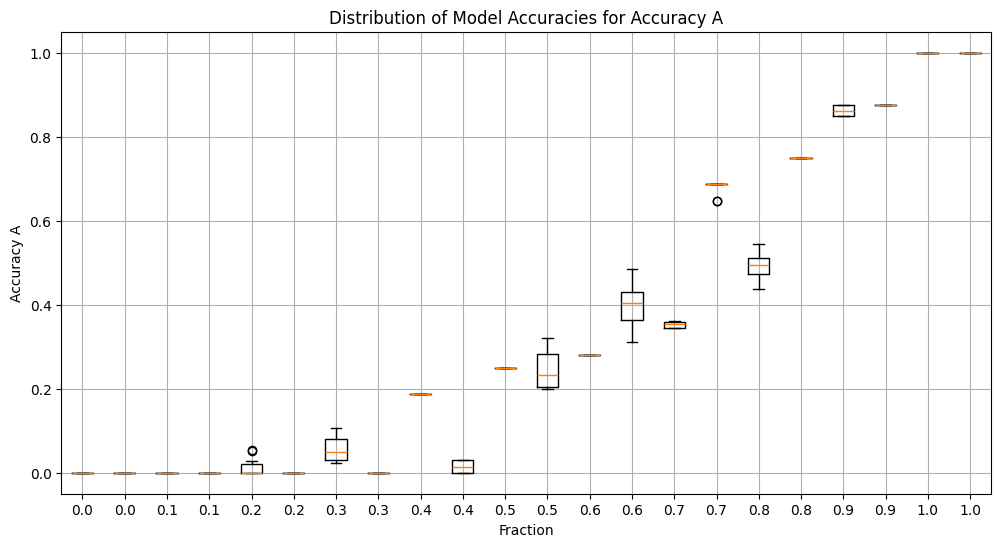

In [47]:
import matplotlib.pyplot as plt

# Assuming all_test_accuracy_A is a dictionary with thresholds as keys and another dictionary as values,
# where the inner dictionary has fractions as keys and lists of accuracies as values.

thresholds = [0.3, 0.5]
fractions = np.arange(0, 101, 10) / 100  # Example fractions

# Prepare data for boxplot
data_for_boxplot_A = [all_test_accuracy_A[thresh][fraction] for fraction in fractions for thresh in thresholds]

# Prepare labels for boxplot
labels_for_boxplot_A = [f"{fraction:.1f}" for fraction in fractions for _ in thresholds]

# Create boxplot for Accuracy A
plt.figure(figsize=(12, 6))
plt.boxplot(data_for_boxplot_A, labels=labels_for_boxplot_A)
plt.title('Distribution of Model Accuracies for Accuracy A')
plt.xlabel('Fraction')
plt.ylabel('Accuracy A')
plt.grid(True)
plt.show()


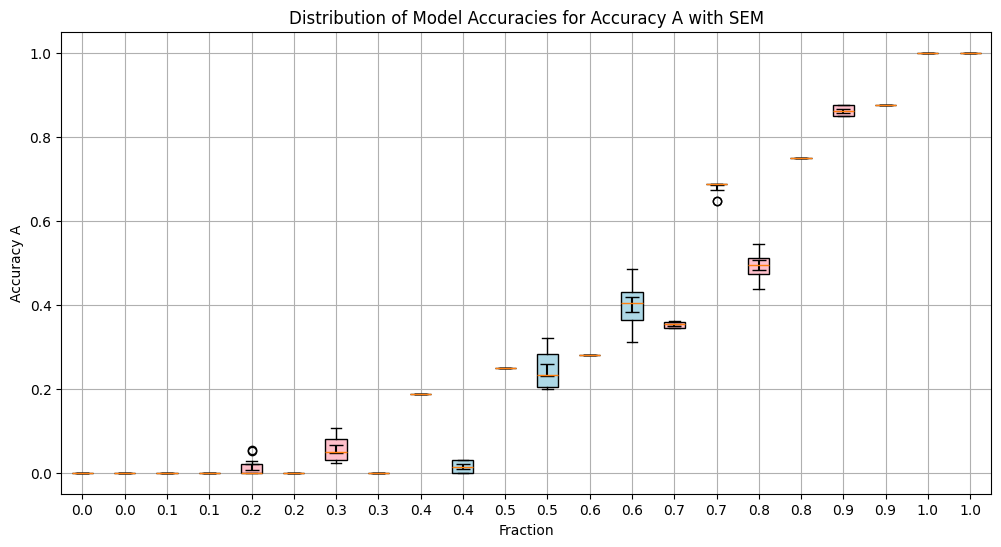

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

thresholds = [0.3, 0.5]
fractions = np.arange(0, 101, 10) / 100  # Example fractions

# Prepare data for boxplot
data_for_boxplot_A = []
sems = []  # List to store standard errors for each fraction
positions = []  # List to store positions of the boxplots to align error bars

for i, fraction in enumerate(fractions):
    for j, thresh in enumerate(thresholds):
        accuracies = all_test_accuracy_A[thresh][fraction]
        data_for_boxplot_A.append(accuracies)
        # Calculate the standard error
        sem = scipy.stats.sem(accuracies, ddof=1) if accuracies else 0
        sems.append(sem)
        # Position for the error bar (i.e., the position of the boxplot)
        positions.append(i * len(thresholds) + j + 1)

# Plot boxplot
plt.figure(figsize=(12, 6))
bp = plt.boxplot(data_for_boxplot_A, positions=positions, patch_artist=True)

# Add standard error bars
plt.errorbar(positions, [np.mean(data) for data in data_for_boxplot_A], yerr=sems, fmt='none', ecolor='black', capsize=5)

# Customize colors of the boxplots
colors = ['pink', 'lightblue']
for patch, color in zip(bp['boxes'], colors * len(fractions)):
    patch.set_facecolor(color)

# Add labels
plt.xticks(range(1, len(labels_for_boxplot_A) + 1), labels_for_boxplot_A)
plt.title('Distribution of Model Accuracies for Accuracy A with SEM')
plt.xlabel('Fraction')
plt.ylabel('Accuracy A')
plt.grid(True)
plt.show()


In [59]:
all_test_accuracy_A

{0.3: [0.0,
  0.0,
  0.0,
  0.045454545454545456,
  0.1875,
  0.25,
  0.28125,
  0.34375,
  0.5,
  0.875,
  1.0],
 0.5: [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.18181818181818182,
  0.5517241379310345,
  0.6875,
  0.75,
  0.875,
  1.0]}

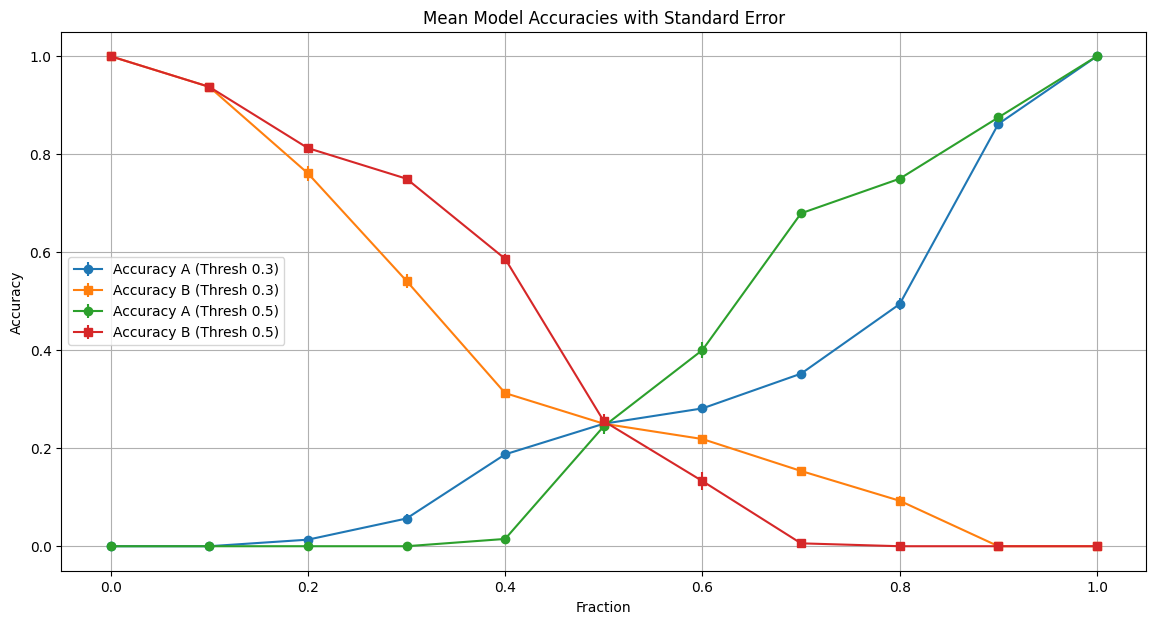

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Assuming all_test_accuracy_A and all_test_accuracy_B are structured as:
# {threshold: {fraction: [list of accuracies]}}

thresholds = [0.3, 0.5]
fractions = np.arange(0, 101, 10) / 100  # Example fractions

# Rounding fractions to match dictionary keys (if that's how they were created)
rounded_fractions = [round(frac, 2) for frac in fractions]

# Prepare the plot
plt.figure(figsize=(14, 7))

# Iterate over thresholds to plot them separately
for thresh in thresholds:
    # Extract mean accuracies and standard errors for each fraction
    mean_accuracies_A = [np.mean(all_test_accuracy_A[thresh][fraction]) for fraction in rounded_fractions]
    mean_accuracies_B = [np.mean(all_test_accuracy_B[thresh][fraction]) for fraction in rounded_fractions]
    std_errors_A = [scipy.stats.sem(all_test_accuracy_A[thresh][fraction]) for fraction in rounded_fractions]
    std_errors_B = [scipy.stats.sem(all_test_accuracy_B[thresh][fraction]) for fraction in rounded_fractions]

    # Plot mean accuracies with standard error bars for accuracy A
    plt.errorbar(rounded_fractions, mean_accuracies_A, yerr=std_errors_A, fmt='-o', label=f'Accuracy A (Thresh {thresh})')

    # Plot mean accuracies with standard error bars for accuracy B
    plt.errorbar(rounded_fractions, mean_accuracies_B, yerr=std_errors_B, fmt='-s', label=f'Accuracy B (Thresh {thresh})')

# Add labels and legend
plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Mean Model Accuracies with Standard Error')
plt.legend()
plt.grid(True)
plt.show()


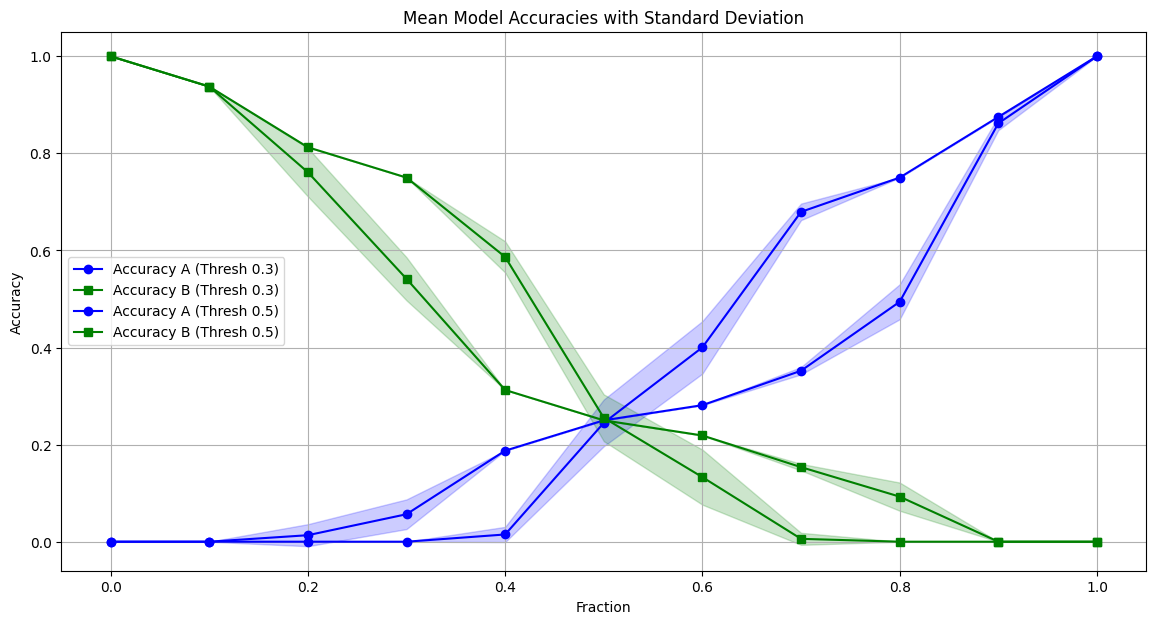

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Assuming all_test_accuracy_A and all_test_accuracy_B are structured as:
# {threshold: {fraction: [list of accuracies]}}

thresholds = [0.3, 0.5]
fractions = np.arange(0, 101, 10) / 100  # Example fractions

# Rounding fractions to match dictionary keys (if that's how they were created)
rounded_fractions = [round(frac, 2) for frac in fractions]

# Prepare the plot
plt.figure(figsize=(14, 7))

# Iterate over thresholds to plot them separately
for thresh in thresholds:
    # Extract mean accuracies and standard deviations for each fraction
    mean_accuracies_A = [np.mean(all_test_accuracy_A[thresh][fraction]) for fraction in rounded_fractions]
    std_devs_A = [np.std(all_test_accuracy_A[thresh][fraction], ddof=1) for fraction in rounded_fractions]
    mean_accuracies_B = [np.mean(all_test_accuracy_B[thresh][fraction]) for fraction in rounded_fractions]
    std_devs_B = [np.std(all_test_accuracy_B[thresh][fraction], ddof=1) for fraction in rounded_fractions]

    # Calculate upper and lower bounds for standard deviation
    upper_A = np.array(mean_accuracies_A) + np.array(std_devs_A)
    lower_A = np.array(mean_accuracies_A) - np.array(std_devs_A)
    upper_B = np.array(mean_accuracies_B) + np.array(std_devs_B)
    lower_B = np.array(mean_accuracies_B) - np.array(std_devs_B)

    # Plot mean accuracies with standard deviation as a shadow for accuracy A
    plt.fill_between(rounded_fractions, lower_A, upper_A, color='blue', alpha=0.2)
    plt.plot(rounded_fractions, mean_accuracies_A, '-o', color='blue', label=f'Accuracy A (Thresh {thresh})')

    # Plot mean accuracies with standard deviation as a shadow for accuracy B
    plt.fill_between(rounded_fractions, lower_B, upper_B, color='green', alpha=0.2)
    plt.plot(rounded_fractions, mean_accuracies_B, '-s', color='green', label=f'Accuracy B (Thresh {thresh})')

# Add labels and legend
plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Mean Model Accuracies with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


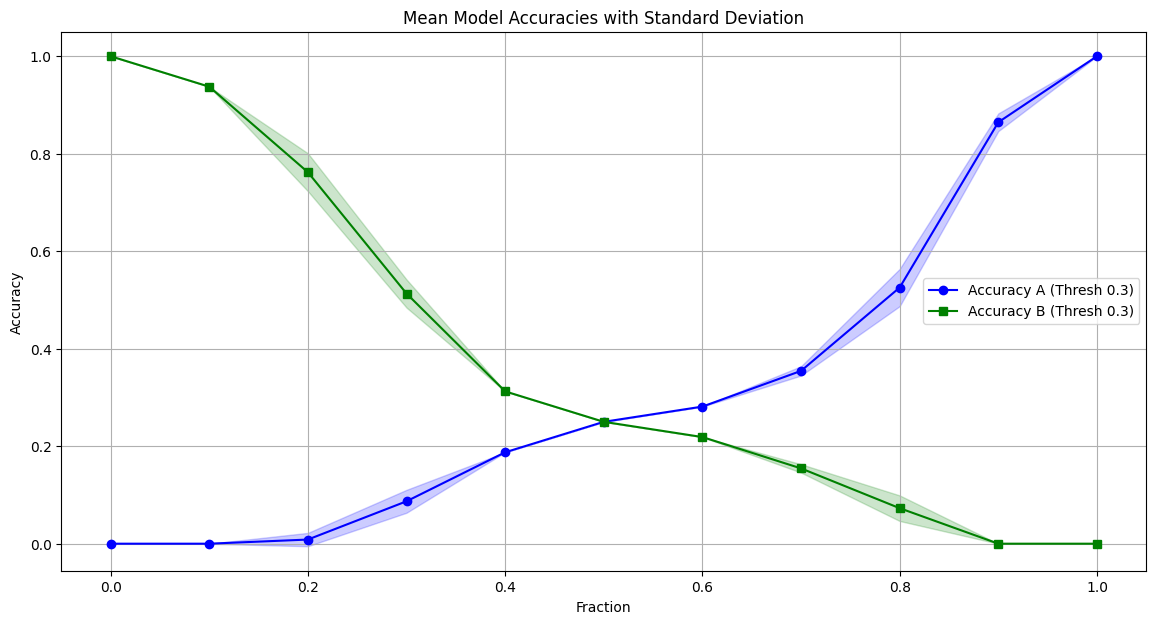

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Assuming all_test_accuracy_A and all_test_accuracy_B are structured as:
# {threshold: {fraction: [list of accuracies]}}

thresholds = [0.3]
fractions = np.arange(0, 101, 10) / 100  # Example fractions

# Rounding fractions to match dictionary keys (if that's how they were created)
rounded_fractions = [round(frac, 2) for frac in fractions]

# Prepare the plot
plt.figure(figsize=(14, 7))

# Iterate over thresholds to plot them separately
for thresh in thresholds:
    # Extract mean accuracies and standard deviations for each fraction
    mean_accuracies_A = [np.mean(all_test_accuracy_A[thresh][fraction]) for fraction in rounded_fractions]
    std_devs_A = [np.std(all_test_accuracy_A[thresh][fraction], ddof=1) for fraction in rounded_fractions]
    mean_accuracies_B = [np.mean(all_test_accuracy_B[thresh][fraction]) for fraction in rounded_fractions]
    std_devs_B = [np.std(all_test_accuracy_B[thresh][fraction], ddof=1) for fraction in rounded_fractions]

    # Calculate upper and lower bounds for standard deviation
    upper_A = np.array(mean_accuracies_A) + np.array(std_devs_A)
    lower_A = np.array(mean_accuracies_A) - np.array(std_devs_A)
    upper_B = np.array(mean_accuracies_B) + np.array(std_devs_B)
    lower_B = np.array(mean_accuracies_B) - np.array(std_devs_B)

    # Plot mean accuracies with standard deviation as a shadow for accuracy A
    plt.fill_between(rounded_fractions, lower_A, upper_A, color='blue', alpha=0.2)
    plt.plot(rounded_fractions, mean_accuracies_A, '-o', color='blue', label=f'Accuracy A (Thresh {thresh})')

    # Plot mean accuracies with standard deviation as a shadow for accuracy B
    plt.fill_between(rounded_fractions, lower_B, upper_B, color='green', alpha=0.2)
    plt.plot(rounded_fractions, mean_accuracies_B, '-s', color='green', label=f'Accuracy B (Thresh {thresh})')

# Add labels and legend
plt.xlabel('Fraction')
plt.ylabel('Accuracy')
plt.title('Mean Model Accuracies with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

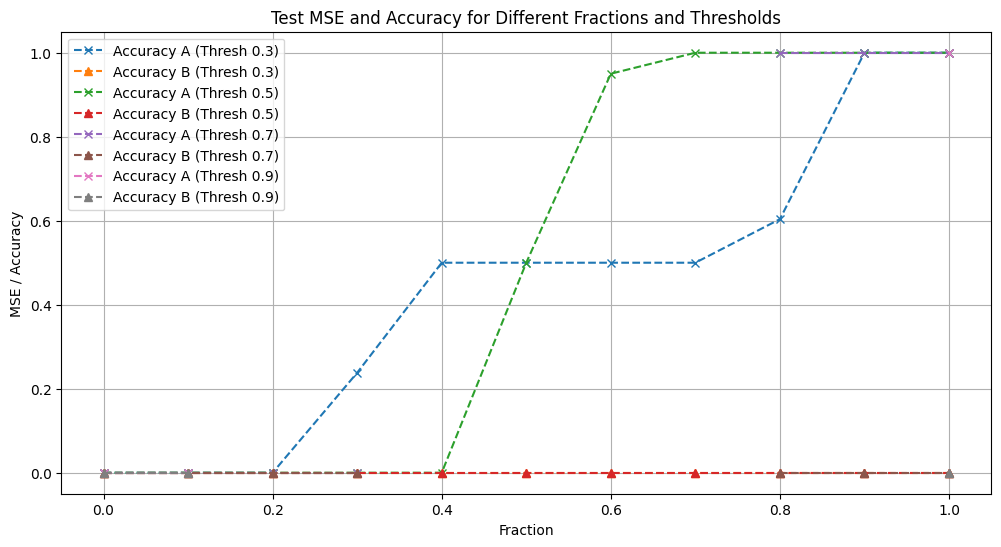

In [24]:

# Directory where the models are saved
models_dir = 'Models_A-B'

# Fractions from 0% to 100%
fractions = np.arange(0, 101, 10) / 100

# Thresholds for accuracy calculation
thresholds = [0.3, 0.5, 0.7, 0.9]

# Initialize dictionaries to store test MSE and accuracies for each fraction and threshold
all_test_mse = []
all_test_accuracy_A = {thresh: [] for thresh in thresholds}
all_test_accuracy_B = {thresh: [] for thresh in thresholds}


for fraction in fractions:
    # Generate Test Data for the current fraction
    #mixedpattern, mixedpattern_plus_1 = createmixedpattern_unchanged(patternA, patternB, patternA_plus_1, patternB_plus_1, fraction)
    mixedpattern, mixedpattern_plus_1 = patternA, patternA_plus_1
    # Dynamically generate model paths for each fraction and load all models
    model_paths = [f'{models_dir}/model_{i+1}_fraction_{int(fraction*100)}.pth' for i in range(3)]  # Adjust for the number of models
    models = [load_model(path) for path in model_paths]

    # Use all models to predict on the same data and average the results
    ensemble_predictions = []
    
    with torch.no_grad():
        for index, model in enumerate(models):
            predicted = model(torch.Tensor(mixedpattern))
            ensemble_predictions.append(predicted.numpy())

        # Calculate the mean prediction across all models
        ensemble_mean_prediction = np.mean(np.stack(ensemble_predictions), axis=0)

        if index == 1 and fraction in [0.9]:

            predicted_tensor = ensemble_mean_prediction  

            # Ensure all patterns have the same shape for plotting
            if predicted_tensor.shape != mixedpattern.shape:
                predicted_tensor = predicted_tensor.reshape(mixedpattern.shape)

            # Plotting the patterns
            plt.figure(figsize=(18, 6))

            # Plot mixedpattern
            plt.subplot(1, 3, 1)
            plt.imshow(mixedpattern, cmap='gray')
            plt.title("Mixed Pattern")
            plt.colorbar()

            # Plot predicted pattern
            plt.subplot(1, 3, 2)
            plt.imshow(predicted_tensor, cmap='gray')
            plt.title("Predicted Pattern")
            plt.colorbar()

            # Plot mixedpattern_plus_1
            plt.subplot(1, 3, 3)
            plt.imshow(mixedpattern_plus_1, cmap='gray')
            plt.title("Mixed Pattern Plus 1")
            plt.colorbar()

            plt.tight_layout()
            plt.show()

        # Calculate MSE
        mse_loss = mean_squared_error(mixedpattern_plus_1, ensemble_mean_prediction)
        all_test_mse.append(mse_loss)

        for thresh in thresholds:
            # Calculate accuracies for A and B
            categorized_predictions = np.select(
                [ensemble_mean_prediction < -thresh, ensemble_mean_prediction < thresh, ensemble_mean_prediction >= thresh],
                [-1, 0, 1]
            )
            # Filter predictions and truth values where predictions are not 0
            filter_mask = categorized_predictions != 0
            filtered_predictions_A = categorized_predictions[filter_mask]
            filtered_truth_A = patternA_plus_1[filter_mask]
            filtered_predictions_B = categorized_predictions[filter_mask]
            filtered_truth_B = patternB_plus_1[filter_mask]

            accuracy_A = np.mean(filtered_predictions_A == filtered_truth_A)
            accuracy_B = np.mean(filtered_predictions_B == filtered_truth_B)
            
            all_test_accuracy_A[thresh].append(accuracy_A)
            all_test_accuracy_B[thresh].append(accuracy_B)

# Plotting results
plt.figure(figsize=(12, 6))
#plt.plot(fractions, all_test_mse, marker='o', linestyle='-', color='red', label='MSE')
for thresh in thresholds:
    plt.plot(fractions, all_test_accuracy_A[thresh], marker='x', linestyle='--', label=f'Accuracy A (Thresh {thresh})')
    plt.plot(fractions, all_test_accuracy_B[thresh], marker='^', linestyle='--', label=f'Accuracy B (Thresh {thresh})')

plt.title('Test MSE and Accuracy for Different Fractions and Thresholds')
plt.xlabel('Fraction')
plt.ylabel('MSE / Accuracy')
plt.legend()
plt.grid(True)
plt.show()
